In [1]:
import sbol2
import os
from rdflib import Graph
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np
import torch
from torch import Tensor
import subprocess
import tempfile
from rdflib.query import ResultRow
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import DataLoader
import random
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, GCNConv, GATConv, global_mean_pool
import sys 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pickle
python_executable = sys.executable


In [2]:
current_dir = os.path.abspath('')
data_path = os.path.join(current_dir, '..', 'data')
attachments_path = os.path.join(current_dir, '..', 'attachments')
pulled_attachments_path = os.path.join(current_dir, '..', 'pulled_attachments')
sbol_path = os.path.join(current_dir, '..', 'sbol_data')
downloaded_sbol_path = os.path.join(current_dir, '..', 'downloaded_sbol')
original_data_path = os.path.join(data_path, 'original_data')
nt_path = os.path.join(current_dir, '..', 'nt_data')
scripts_path = os.path.join(current_dir, 'scripts')
model_data_path = os.path.join(data_path, 'processed_data', 'replicated_models')
model_output_path = os.path.join('..', 'model_outputs')

In [61]:
def xml_to_nt_and_get_y_measure(file_name):
    g = Graph()
    g.parse(os.path.join(sbol_path, file_name), format="xml")
    g.serialize(destination=os.path.join(nt_path, file_name.replace(".xml", ".nt")), format="nt")

    sparql_query ='''PREFIX om: <http://www.ontology-of-units-of-measure.org/resource/om-2/>

    SELECT ?numericalValue
    WHERE {
    ?s om:hasNumericalValue ?numericalValue .
    }
    '''
    query_result = g.query(sparql_query)

    # Process the results
    if query_result:
        for row in query_result:
            if isinstance(row, ResultRow):
                return float(row.numericalValue) 
                
            else:
                print(row)
    else:
        print("No numerical values found.")
    

def convert_all_xml_to_nt_and_get_y_measures():
    y_measures = []
    for file_name in os.listdir(os.path.join(sbol_path)):
        y = xml_to_nt_and_get_y_measure(file_name)
        y_measures.append(y)
    return y_measures

def return_heterograph_for_one_nt(nt_file_name, node_names, edge_names):
    
    with tempfile.TemporaryDirectory() as temp_dir:
        save_path_numeric = os.path.join(temp_dir, "save_path_numeric")
        path = os.path.join(temp_dir, "path")
        os.makedirs(save_path_numeric, exist_ok=True)
        os.makedirs(path, exist_ok=True)

        content_config_string = f'''
        [InputPath]
        input_path = {os.path.join(nt_path, nt_file_name)}

        [SavePath]
        save_path_numeric_graph = {save_path_numeric}
        save_path_mapping = {path}

        [NLD]
        nld_class = ModuleDefinition

        [EMBEDDING]
        embedding_model = allenai/scibert_scivocab_uncased

        [Nodes]
        classes = ComponentDefinition, Sequence, ModuleDefinition, Module, FunctionalComponent, Component, SequenceAnnotation, Range

        ComponentDefinition = http://sbols.org/v2#ComponentDefinition
        Sequence = http://sbols.org/v2#Sequence
        ModuleDefinition = http://sbols.org/v2#ModuleDefinition
        Module = http://sbols.org/v2#Module
        FunctionalComponent = http://sbols.org/v2#FunctionalComponent
        Component = http://sbols.org/v2#Component
        SequenceAnnotation = http://sbols.org/v2#SequenceAnnotation
        Range = http://sbols.org/v2#Range

        [SimpleEdges]
        edge_names = ComponentDefinition_Sequence, ComponentDefinition_SequenceAnnotation
        ComponentDefinition_Sequence_start_node = ComponentDefinition
        ComponentDefinition_Sequence_properties = http://sbols.org/v2#sequence
        ComponentDefinition_Sequence_end_node = Sequence
        ComponentDefinition_SequenceAnnotation_start_node = ComponentDefinition
        ComponentDefinition_SequenceAnnotation_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_SequenceAnnotation_end_node = SequenceAnnotation

        [N-HopEdges]
        edge_names = ComponentDefinition_Range, ModuleDefinition_ComponentDefinition, ModuleDefinition_ModuleDefinition, ComponentDefinition_ComponentDefinition
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_hop1_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_Range_hop2_properties = http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range
        ModuleDefinition_ComponentDefinition_start_node = ModuleDefinition
        ModuleDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#functionalComponent
        ModuleDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ComponentDefinition_end_node = ComponentDefinition
        ModuleDefinition_ModuleDefinition_start_node = ModuleDefinition
        ModuleDefinition_ModuleDefinition_hop1_properties = http://sbols.org/v2#module
        ModuleDefinition_ModuleDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ModuleDefinition_end_node = ModuleDefinition
        ComponentDefinition_ComponentDefinition_start_node = ComponentDefinition
        ComponentDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#component
        ComponentDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ComponentDefinition_ComponentDefinition_end_node = ComponentDefinition

        [N-ArayEdges]
        edge_names = ComponentDefinition_Range
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_properties = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range

        [N-ArayFeaturePath]
        ComponentDefinition_Range_feature_path = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location

        [N-ArayFeatureValue]
        ComponentDefinition_Range_feature_value = http://sbols.org/v2#start, http://sbols.org/v2#end
        '''

        topo_config_string = f'''
        [InputPath]
        input_path = {os.path.join(nt_path, nt_file_name)}

        [SavePath]
        save_path_numeric_graph = {save_path_numeric}
        save_path_mapping = {path}

        [MODEL] ;required, options = transe / complex / distmult / rotate
        kge_model = distmult

        [Nodes]
        classes = ComponentDefinition, Sequence, ModuleDefinition, Module, FunctionalComponent, Component, SequenceAnnotation, Range

        ComponentDefinition = http://sbols.org/v2#ComponentDefinition
        Sequence = http://sbols.org/v2#Sequence
        ModuleDefinition = http://sbols.org/v2#ModuleDefinition
        Module = http://sbols.org/v2#Module
        FunctionalComponent = http://sbols.org/v2#FunctionalComponent
        Component = http://sbols.org/v2#Component
        SequenceAnnotation = http://sbols.org/v2#SequenceAnnotation
        Range = http://sbols.org/v2#Range

        [SimpleEdges]
        edge_names = ComponentDefinition_Sequence, ComponentDefinition_SequenceAnnotation
        ComponentDefinition_Sequence_start_node = ComponentDefinition
        ComponentDefinition_Sequence_properties = http://sbols.org/v2#sequence
        ComponentDefinition_Sequence_end_node = Sequence
        ComponentDefinition_SequenceAnnotation_start_node = ComponentDefinition
        ComponentDefinition_SequenceAnnotation_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_SequenceAnnotation_end_node = SequenceAnnotation

        [N-HopEdges]
        edge_names = ComponentDefinition_Range, ModuleDefinition_ComponentDefinition, ModuleDefinition_ModuleDefinition, ComponentDefinition_ComponentDefinition
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_hop1_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_Range_hop2_properties = http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range
        ModuleDefinition_ComponentDefinition_start_node = ModuleDefinition
        ModuleDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#functionalComponent
        ModuleDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ComponentDefinition_end_node = ComponentDefinition
        ModuleDefinition_ModuleDefinition_start_node = ModuleDefinition
        ModuleDefinition_ModuleDefinition_hop1_properties = http://sbols.org/v2#module
        ModuleDefinition_ModuleDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ModuleDefinition_end_node = ModuleDefinition
        ComponentDefinition_ComponentDefinition_start_node = ComponentDefinition
        ComponentDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#component
        ComponentDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ComponentDefinition_ComponentDefinition_end_node = ComponentDefinition

        [N-ArayEdges]
        edge_names = ComponentDefinition_Range
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_properties = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range

        [EmbeddingClasses] 
        class_list = http://sbols.org/v2#ComponentDefinition, http://sbols.org/v2#Sequence, http://sbols.org/v2#ModuleDefinition, http://sbols.org/v2#Module, http://sbols.org/v2#FunctionalComponent, http://sbols.org/v2#Component, http://sbols.org/v2#SequenceAnnotation, http://sbols.org/v2#Range

        [EmbeddingPredicates] 
        pred_list = http://sbols.org/v2#location, http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#functionalComponent, http://sbols.org/v2#definition, http://sbols.org/v2#module, http://sbols.org/v2#component, https://sbols.org/v2#sequence, http://www.w3.org/1999/02/22-rdf-syntax-ns#type
        '''

        with open(os.path.join(temp_dir,'config.ini'), 'w') as file:
            file.write(content_config_string)

        with open(os.path.join(temp_dir,'topo-config.ini'), 'w') as file:
            file.write(topo_config_string)

        content_result = subprocess.run([python_executable, "autordf2gml.py", "--config_path", os.path.join(temp_dir,"config.ini")], shell=False, capture_output=True, text=True)
        topo_result = subprocess.run([python_executable, "autordf2gml-tb.py", "--config_path", os.path.join(temp_dir,"topo-config.ini")], shell=False, capture_output=True, text=True, encoding='utf-8', errors='replace')

        if (topo_result.returncode != 0):
            print(f"topology-based conversion failed with return code {topo_result.returncode}.")

        if (content_result.returncode != 0):
            print(f"content-based conversion failed with return code {content_result.returncode}.")
        
        data = HeteroData()
        local_indices_map = {}            

        for node_name in node_names:
            node_features_df = pd.read_csv(os.path.join(save_path_numeric, f'pivoted_df_{node_name}.csv'), header=None).astype(float)
            node_tensor = torch.tensor(node_features_df.values, dtype=torch.float)
            id_mapping_df = pd.read_csv(os.path.join(path, f'pivoted_df_{node_name}.csv'))
            subject_mapping_dict = id_mapping_df.set_index('subject')['mapping'].to_dict()

            topo_df = pd.read_csv(os.path.join(save_path_numeric, f"uri_list_{node_name}.csv"))
            topo_df['mapped_col'] = topo_df['subject'].map(subject_mapping_dict)
            topo_df = topo_df.sort_values(by='mapped_col')
            topo_df = topo_df.drop(['subject', 'mapped_col'], axis=1).astype(float)
            node_tensor_topo = torch.tensor(topo_df.values, dtype=torch.float)


            node_tensor = torch.concat([node_tensor, node_tensor_topo], dim=1)
            
            data[node_name].node_id = torch.arange(len(id_mapping_df))
            data[node_name].x = node_tensor
            local_indices_map = subject_mapping_dict | local_indices_map
                
        for edge in edge_names:
            df = pd.read_csv( os.path.join(save_path_numeric, f"edge_list_{edge}.csv"), header=None)
            
            src = df[0].values
            dst = df[1].values

            src = torch.tensor([local_indices_map[src[i]] for i in range(len(src))], dtype=torch.long)
            dst = torch.tensor([local_indices_map[dst[i]] for i in range(len(dst))], dtype=torch.long)
            data[edge.split("_")[0], f'has_{edge.split("_")[1]}', edge.split("_")[1]].edge_index = torch.stack([src, dst], dim=0)
        
        return data
    
class HeteroGNN_GraphLevel(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, num_layers):
        super().__init__()
        self.metadata = metadata  # (node_types, edge_types)

        has_seq = ('ComponentDefinition', 'has_Sequence', 'Sequence')
        has_seq_anno = ('ComponentDefinition', 'has_SequenceAnnotation', 'SequenceAnnotation')
        has_range = ('ComponentDefinition', 'has_Range', 'Range')
        has_comp = ('ModuleDefinition', 'has_ComponentDefinition', 'ComponentDefinition')
        comp_has_comp = ('ComponentDefinition', 'has_ComponentDefinition', 'ComponentDefinition')
        has_mod = ('ModuleDefinition', 'has_ModuleDefinition', 'ModuleDefinition')

        edges = [has_seq, has_seq_anno, has_range, has_comp, comp_has_comp, has_mod]

        unique_nodes = set()

        for edge_tuple in edges:
            unique_nodes.add(edge_tuple[0])
            unique_nodes.add(edge_tuple[2])


        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                has_seq:SAGEConv((-1, -1), hidden_channels),
                has_seq_anno: SAGEConv((-1, -1), hidden_channels),
                has_comp: GATConv((-1, -1), hidden_channels, add_self_loops=False),
                has_mod: GCNConv(-1, hidden_channels),
                comp_has_comp: GCNConv(-1, hidden_channels),
                has_range: GATConv((-1, -1), hidden_channels, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)
      
        total_hidden = len(unique_nodes) * hidden_channels
        self.lin = torch.nn.Sequential(
            Linear(total_hidden, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.7),
            Linear(hidden_channels, 1) 
        )

    def forward(self, x_dict, edge_index_dict, batch_dict):

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {k: F.relu(v) for k, v in x_dict.items()}


        # Pool all node types, then concatenate
        pooled = [
            global_mean_pool(x_dict[node_type], batch_dict[node_type])
            for node_type in x_dict
        ]        
        graph_embeddings = torch.cat(pooled, dim=-1)  # shape: [batch_size, total_hidden]
        return self.lin(graph_embeddings).view(-1)     # shape: [batch_size]

def return_all_graphs(node_classes, y_measures, all_edges_formatted):
    all_data = []
    files = os.listdir(nt_path)
    
    for i, filename in enumerate(tqdm(files, desc="Generating graphs")):
        data = return_heterograph_for_one_nt(filename, node_classes, all_edges_formatted)
        data.y = y_measures[i]
        all_data.append(data)
    
    return all_data



def evaluate_on_test(model, test_loader, device):
    model.eval()
    total_test_loss = 0
    preds = []
    trues = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
            target = batch.y.float().view(-1).to(device)
            loss = F.mse_loss(out, target)
            total_test_loss += loss.item() * batch.num_graphs

            preds.extend(out.cpu().numpy())
            trues.extend(target.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    print(f"Test Loss (MSE): {avg_test_loss}")
    return avg_test_loss, preds, trues


def train_GNN(all_data):

    random.shuffle(all_data)
    train_size = int(0.8 * len(all_data))
    train_data = all_data[:train_size]
    val_data = all_data[train_size:]

    train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=10, shuffle=False) 

    model = HeteroGNN_GraphLevel(metadata=all_data[0].metadata(), hidden_channels=256, num_layers=5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    history = {
    "train_loss": [],
    "val_loss": []
    }

    for epoch in range(1, 100):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
            target = torch.tensor(batch.y, dtype=torch.float32).view(-1).to(device)
            loss = F.mse_loss(out, target)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch.num_graphs

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
                target = batch.y.float().view(-1).to(device)
                loss = F.mse_loss(out, target)
                total_val_loss += loss.item() * batch.num_graphs

        train_epoch_loss = total_train_loss / len(train_loader.dataset)
        val_epoch_loss = total_val_loss / len(val_loader.dataset)
        history["train_loss"].append(train_epoch_loss)
        history["val_loss"].append(val_epoch_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")
    return model, history, device



In [51]:
node_classes = [
    "ComponentDefinition",
    "Sequence",
    "ModuleDefinition",
    "Module",
    "FunctionalComponent",
    "Component",
    "SequenceAnnotation",
    "Range"
]

all_edges_formatted = [
    "ComponentDefinition_Sequence",
    "ComponentDefinition_SequenceAnnotation",
    "ComponentDefinition_Range",
    "ModuleDefinition_ComponentDefinition",
    "ModuleDefinition_ModuleDefinition",
    "ComponentDefinition_ComponentDefinition",
]

def return_standardized_labels(y_measures):
    all_y_values_np = np.array(y_measures).reshape(-1, 1)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(all_y_values_np)
    return y_scaled, scaler_y



In [52]:
with open('numbers.pkl', 'rb') as file:
    y = pickle.load(file)

y_scaled, scaler_y = return_standardized_labels(y)
y_scaled = y_scaled[:5]

with open('heterographs.pkl', 'rb') as file:
    X_graphs = pickle.load(file)

for graph, y_measure in zip(X_graphs, y_scaled):
    graph.y = torch.tensor(y_measure, dtype=torch.float32)

In [53]:
X_graphs = X_graphs[:200]

In [54]:
train_graphs, test_graphs = train_test_split(X_graphs, test_size=0.2, random_state=42)

In [62]:
model, history, device = train_GNN(train_graphs)


C:\Users\Sai\AppData\Local\Temp\ipykernel_48852\2557629503.py:342: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch.y, dtype=torch.float32).view(-1).to(device)


Epoch 001 | Train Loss: 0.0448 | Val Loss: 2.1146
Epoch 002 | Train Loss: 0.0177 | Val Loss: 2.1026
Epoch 003 | Train Loss: 0.0181 | Val Loss: 2.1157
Epoch 004 | Train Loss: 0.0155 | Val Loss: 2.1129
Epoch 005 | Train Loss: 0.0135 | Val Loss: 2.1014
Epoch 006 | Train Loss: 0.0129 | Val Loss: 2.1121
Epoch 007 | Train Loss: 0.0027 | Val Loss: 2.1024
Epoch 008 | Train Loss: 0.0301 | Val Loss: 2.1158
Epoch 009 | Train Loss: 0.0154 | Val Loss: 2.1093
Epoch 010 | Train Loss: 0.0143 | Val Loss: 2.1369
Epoch 011 | Train Loss: 0.0131 | Val Loss: 2.1197
Epoch 012 | Train Loss: 0.0117 | Val Loss: 2.1243
Epoch 013 | Train Loss: 0.0106 | Val Loss: 2.1239
Epoch 014 | Train Loss: 0.0062 | Val Loss: 2.1335
Epoch 015 | Train Loss: 0.0064 | Val Loss: 2.1215
Epoch 016 | Train Loss: 0.0102 | Val Loss: 2.1269
Epoch 017 | Train Loss: 0.0043 | Val Loss: 2.1275
Epoch 018 | Train Loss: 0.0030 | Val Loss: 2.1268
Epoch 019 | Train Loss: 0.0027 | Val Loss: 2.1246
Epoch 020 | Train Loss: 0.0076 | Val Loss: 2.1247


In [68]:
test_loader = DataLoader(test_graphs, batch_size=100, shuffle=False)


test_loss, y_pred, y_true = evaluate_on_test(model, test_loader, device)
y_pred_unnorm = scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_unnorm = scaler_y.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()

from sklearn.metrics import r2_score, mean_absolute_error

print("MAE:", mean_absolute_error(y_true_unnorm, y_pred_unnorm))
print("R²:", r2_score(y_true_unnorm, y_pred_unnorm))


Test Loss (MSE): 0.004736785311251879
MAE: 0.21027150750160217
R²: -0.18471527099609375


In [67]:
print(np.round(y_pred[:100], 3))  # predictions
print(np.round(y_true[:100], 3))  # true labels

[-0.088 -0.105 -0.098 -0.078 -0.098 -0.084 -0.087 -0.077 -0.094 -0.096
 -0.082 -0.096 -0.101 -0.086 -0.087 -0.088 -0.1   -0.09  -0.107 -0.107
 -0.089 -0.085 -0.102 -0.087 -0.096 -0.078 -0.073 -0.082 -0.093 -0.091
 -0.099 -0.088 -0.094 -0.112 -0.082 -0.104 -0.09  -0.092 -0.073 -0.085]
[-0.097 -0.057 -0.1   -0.089  0.07  -0.096 -0.103 -0.11  -0.106  0.232
 -0.065 -0.055 -0.095 -0.101 -0.093 -0.089 -0.072 -0.117 -0.087 -0.088
 -0.065 -0.092  0.076 -0.076 -0.092 -0.1   -0.104 -0.092 -0.087 -0.116
 -0.082 -0.111 -0.097 -0.085 -0.084 -0.015 -0.105 -0.099 -0.082 -0.112]


tensor(nan) tensor(8.1564)
tensor(nan) tensor(-0.1133)
tensor(nan) tensor(-0.0932)


C:\Users\Sai\AppData\Local\Temp\ipykernel_48852\1387030842.py:2: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  print(graph.y.std(), graph.y.mean())


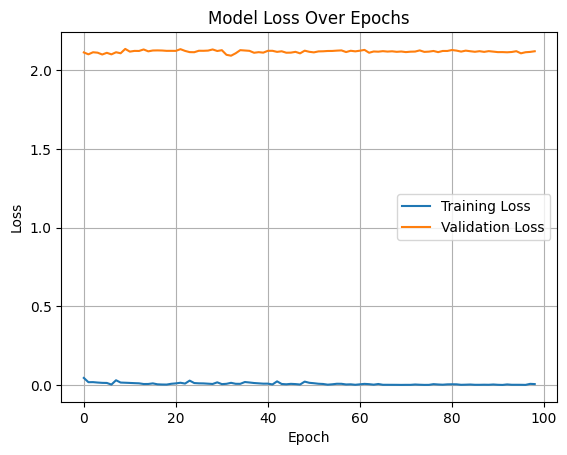

In [63]:

# If you have history from model.fit(...)
history_dict = history

# Plot training & validation loss
plt.plot(history_dict['train_loss'], label='Training Loss')

# Check if validation loss exists
if 'val_loss' in history_dict:
    plt.plot(history_dict['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
data = HeteroData()
for node in node_classes:

    node_features_df = pd.read_csv(os.path.join("save_path_numeric", f'pivoted_df_{node}.csv'), header=None).astype(float)
    node_tensor = torch.tensor(node_features_df.values, dtype=torch.float)
    id_mapping_df = pd.read_csv(os.path.join("path", f'pivoted_df_{node}.csv'))
    subject_mapping_dict = id_mapping_df.set_index('subject')['mapping'].to_dict()

    topo_df = pd.read_csv(f"save_path_numeric/uri_list_{node}.csv")
    topo_df['mapped_col'] = topo_df['subject'].map(subject_mapping_dict)
    topo_df = topo_df.sort_values(by='mapped_col')
    topo_df.drop(['subject', 'mapped_col'], axis=1, inplace=True)
    node_tensor_topo = torch.tensor(topo_df.values, dtype=torch.float)

    node_tensor = torch.concat([node_tensor, node_tensor_topo], dim=1)
    print(node_tensor.shape)
print(data)

FileNotFoundError: [Errno 2] No such file or directory: 'save_path_numeric\\pivoted_df_ComponentDefinition.csv'

In [25]:
subprocess.run([python_executable, "autordf2gml-tb.py", "--config_path", "top-config.ini"], shell=False, capture_output=True, text=True, encoding='utf-8')

CompletedProcess(args=['c:\\Users\\Sai\\Documents\\GitHub\\SBOLtrainer\\autordf-env\\Scripts\\python.exe', 'autordf2gml-tb.py', '--config_path', 'top-config.ini'], returncode=0, stdout="## AutoRDF2GML (topology-based): START! ##\n## start_time=1753241011.751575\n## Loading the config file: top-config.ini\n## Configs: input:../nt_data/sample_design_definition_0.nt / output:path/ save_path_numeric/ / kge_model='distmult'\n## Path exists: save_path_numeric/\n## Path exists: path/\n## Loading the RDF dump from: file_path='../nt_data/sample_design_definition_0.nt'...\n## RDF dump file loaded. The RDF graph contains 141 triples.\n## Transformation started! Automatic features extraction..\n{rdflib.term.URIRef('https://synbiohub.org/user/cywong/Ecolipromoterexpdataalt/ModuleDefinition_strain_definition_0/chassis_module_0/1'): 0, rdflib.term.URIRef('https://synbiohub.org/user/cywong/Ecolipromoterexpdataalt/ModuleDefinition_sample_design_definition_0/strain_module_0/1'): 1, rdflib.term.URIRef('h